# Label studio 
This file is used to help create the precise test annotations using Label Studio. The process is: 
<ul>
<li> We use a rough model to create rough annotations for each test instance
<li> Load these into Label Studio
<li> Correct the labels with the help of RGB and NGB images and Google Earth pro 
<li> Save the precise test annotations
</ul>
After obtianing the precise test annotations, we append them to the test instances in 3_model_data.ipynb

In [22]:
from label_studio_sdk import Client
from label_studio_converter import brush

import matplotlib.pyplot as plt
import numpy as np
import os
from train_landsat_unet import * #load dataset and model classes

import importlib
import utils
importlib.reload(utils)

base_path = '../data/'

LABEL_STUDIO_URL = 'http://localhost:8080'
API_KEY = '15242b278b8437ea3ddc0f383ece4791fa4a4d1e'

ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)

## Use rough model to create initial annotations

In [2]:
import torch

# Set device
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

# Load saved model 
model = torch.load('../models/LANDSAT-ALL-16JUN23.pth', map_location=torch.device('cpu') )
model.eval()
model.to(device)

Using device: mps



build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(7, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (elu): ELU(alpha=1.0)
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (elu): ELU(alpha=1.0)
    )
    (pool): MaxPool2d(kernel_s

In [3]:
# Load dataset
def get_loader(paths):

    test_data = TrainDataset(paths)
    test_loader = DataLoader(test_data, batch_size=test_data.__len__())

    print(test_data.__len__())
    return test_loader

def get_preds(loader):
    images, target = next(iter(loader))
    images = images.to(device)

    # Get model output
    output = model(images)
    print(output.shape)
    # Get model predictions 
    targets = [np.array(t[1]) for t in target] 

    preds = [np.round(out) for out in output.cpu().detach()]
    preds = [np.array(pred[0]) for pred in preds] #use land mask only

    return images, targets, preds

In [4]:
df_label = pd.read_csv('../data/label_scenes.csv')
df_label.head()

# get predictions from rough model
paths = [base_path + f"test/{i}.npy" for i in df_label['id']]
test_loader = get_loader(paths)
images, targets, masks = get_preds(test_loader)

NameError: name 'get_loader' is not defined

In [45]:
# load predictions to label studio
project = ls.get_project(3)
tasks_ids = project.get_tasks_ids()
print(len(tasks_ids))

for i in range(100):
    mask = masks[i].astype(np.uint8)*255

    rle = brush.mask2rle(mask)

    project.create_prediction(
        task_id=tasks_ids[i],
        model_version=None,
        result=[
            {
                "from_name": "brush_labels_tag",
                "to_name": "image",
                "type": "brushlabels",
                'value': {"format": "rle", "rle": rle, "brushlabels":'Land'},
            }
        ],
    )

# Plot summary charts to help with labelling

In [29]:
import json
import utm
from pyproj import CRS
final_crop = json.load(open(base_path + 'final_test_crops.json'))


def plot_test_summary(id,tile,stack):
    fig, ax = plt.subplots(2,1,figsize=(10,20))
    # Get lat long of crop
    geo = utils.get_geolocation(id)
    espg = geo.crs.to_epsg() 
    crs_utm = CRS.from_user_input(espg)
    zone_letter = crs_utm.utm_zone[-1]
    zone_number = int(crs_utm.utm_zone[:-1])

    utmx,utmy = final_crop[tile]
    lat,long = utm.to_latlon(utmx,utmy,zone_number,zone_letter)

    print(id, lat, long)

    rgb = utils.rgb_from_stack(stack, False, contrast=0.2)
    igb = utils.rgb_from_stack(stack, True, contrast=0.2)

    ax[0].imshow(rgb)
    ax[0].set_title(id)
    ax[1].imshow(igb)
    ax[1].set_title(str((lat,long)))

2002-03-14 11:12:43.604880
LT05_L2SP_208022_20020314_20200905_02_T1 54.02637134538241 -10.180032410569995


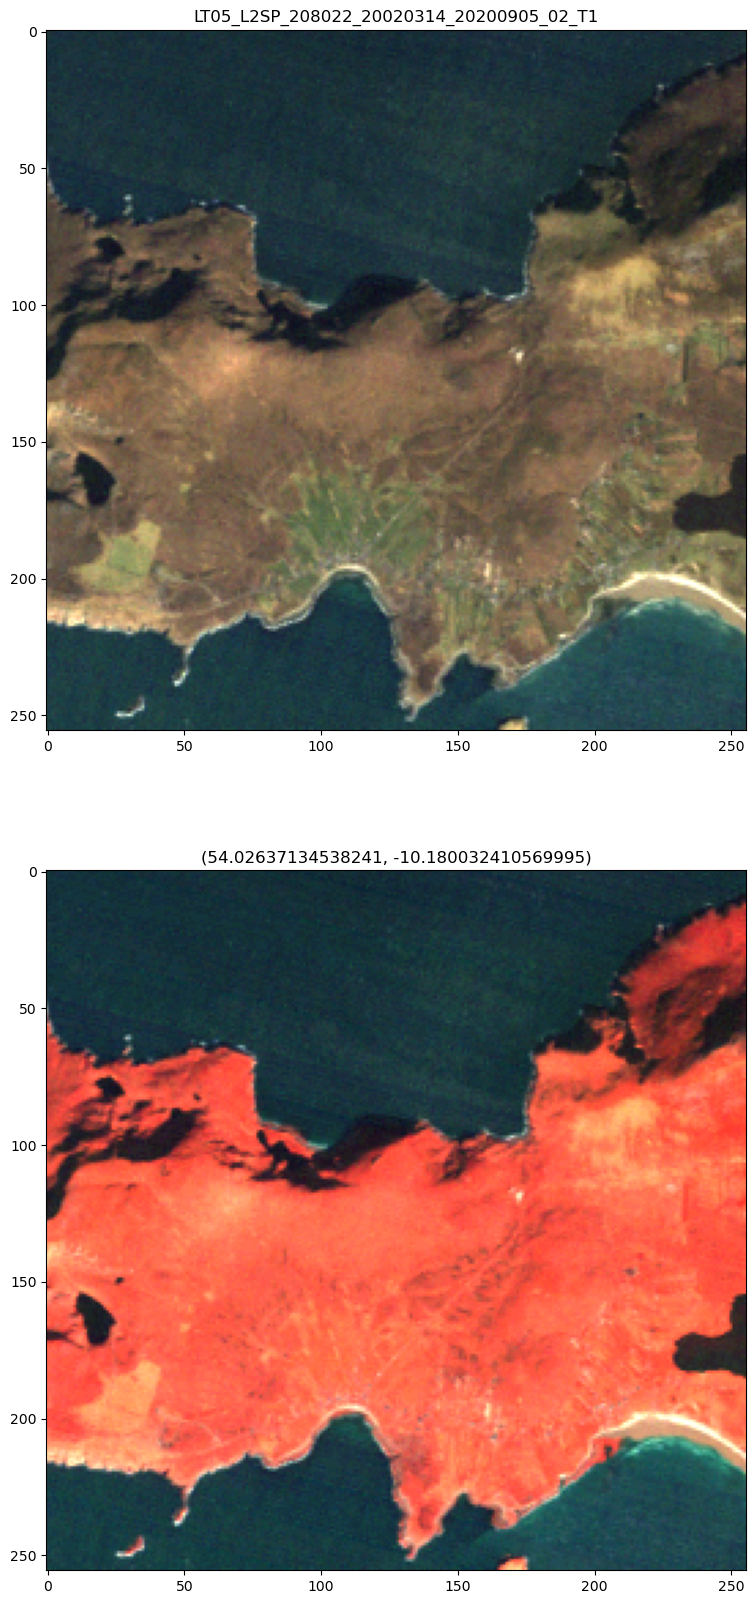

In [75]:
i = 91
id = df_label['id'][i-1]
print(df_label['time'][i-1])
tile = df_label['tile'][i-1]

stack = utils.get_stack(id,path = 'test')
plot_test_summary(id,tile,stack)